In [52]:
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
# import neptune
import datetime

In [53]:
args = {}
args['data_folder'] = './Data'
args['data_filename'] = 'full_data_2014to2021.pkl'
args['summarize_n_games']= 10
args['columns_to_summarize']=['Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg', 'TS%', 
                              '3PAr', 'FTr', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'DRtg']
args['summarize_method']='mean'
args['columns_order'] = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
                         'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
                         'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 
                         'DRB%_home', 'TRB%_home','AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home',
                         'Pace_visitor', 'eFG%_visitor','TOV%_visitor', 'ORB%_visitor', 
                         'FT/FGA_visitor', 'ORtg_visitor','TS%_visitor',
                         '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
                         'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
                         'season', 'season_nth_game', 'hometeam_nth_homegame','visitorteam_nth_visitorgame',
                         'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN']
args['home_columns_to_summarize']=[column + '_'+'home' for column in args['columns_to_summarize']]
args['visitor_columns_to_summarize']=[column + '_'+'visitor' for column in args['columns_to_summarize']]
args['processed_dataset_filename']= "ProcessedDataset_TeamBasis_mean_Past10Games_SameHomeVisitorStatus_2021-02-21.pkl"

args['random_state']=248 # RIP Kobe

In [54]:
data_folder = Path(args['data_folder'])
assert data_folder.exists()

# Read Raw Data

In [5]:
dataset_df = pd.read_pickle(data_folder/args['data_filename'])
dataset_df.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,season,season_nth_game,hometeam_nth_homegame,visitorteam_nth_visitorgame
0,2013-10-29,ORL,87,IND,97,https://www.basketball-reference.com/boxscores...,201310290IND,95.0,0.528,19.0,...,72.2,47.0,47.2,10.5,11.1,102.1,2014-2015,1,1,1
1,2013-10-29,CHI,95,MIA,107,https://www.basketball-reference.com/boxscores...,201310290MIA,97.1,0.590,17.5,...,85.7,50.6,65.7,11.3,7.7,110.2,2014-2015,2,1,1
2,2013-10-29,LAC,103,LAL,116,https://www.basketball-reference.com/boxscores...,201310290LAL,100.4,0.527,15.3,...,62.5,43.5,65.9,11.0,6.3,115.6,2014-2015,3,1,1
3,2013-10-30,BRK,94,CLE,98,https://www.basketball-reference.com/boxscores...,201310300CLE,92.3,0.446,10.0,...,63.6,43.5,72.7,8.7,11.6,106.2,2014-2015,4,1,1
4,2013-10-30,BOS,87,TOR,93,https://www.basketball-reference.com/boxscores...,201310300TOR,91.5,0.471,15.0,...,57.8,40.7,46.9,10.9,10.1,101.6,2014-2015,5,1,1


In [6]:
# convert string columns to numeric columns
for column in ['VISITOR_PTS','HOME_PTS']:
    dataset_df[column] = pd.to_numeric(dataset_df[column])

In [7]:
numeric_col=[]
for col_name in args['columns_to_summarize']:
    numeric_col.append(col_name+'_home')
    numeric_col.append(col_name+'_visitor')
numeric_col

['Pace_home',
 'Pace_visitor',
 'eFG%_home',
 'eFG%_visitor',
 'TOV%_home',
 'TOV%_visitor',
 'ORB%_home',
 'ORB%_visitor',
 'FT/FGA_home',
 'FT/FGA_visitor',
 'ORtg_home',
 'ORtg_visitor',
 'TS%_home',
 'TS%_visitor',
 '3PAr_home',
 '3PAr_visitor',
 'FTr_home',
 'FTr_visitor',
 'DRB%_home',
 'DRB%_visitor',
 'TRB%_home',
 'TRB%_visitor',
 'AST%_home',
 'AST%_visitor',
 'STL%_home',
 'STL%_visitor',
 'BLK%_home',
 'BLK%_visitor',
 'DRtg_home',
 'DRtg_visitor']

In [8]:
dataset_df[numeric_col] = dataset_df[numeric_col].astype('float')

In [51]:
dataset_df.info()

NameError: name 'dataset_df' is not defined

In [10]:
dataset_df.columns

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
       'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
       'FT/FGA_home', 'ORtg_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home',
       'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'TS%_visitor',
       '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
       'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
       'season', 'season_nth_game', 'hometeam_nth_homegame',
       'visitorteam_nth_visitorgame'],
      dtype='object')

In [11]:
dataset_df['TOTAL_PTS'] = dataset_df['VISITOR_PTS']+dataset_df['HOME_PTS']
dataset_df['HOME_VISITOR_PTS_DIFF'] = dataset_df['HOME_PTS']-dataset_df['VISITOR_PTS']
dataset_df['HOME_WIN'] = (dataset_df['HOME_VISITOR_PTS_DIFF']>0)

In [14]:
dataset_df = dataset_df[args['columns_order']]

# Data Processing

In [ ]:
# get most recent x games data as training data
# test on 2021 data
    # sort by dates
    # iterate rows
    # get current index
    # from current index, go backwards index until found previous X games
        # if out of index before fetching X games, stop and continue (give up predicting this game)
    # if HOME or VISITOR equals to current row HOME, then get that row
    # save into a dictionary, key is game_id
    # transform as data frame, and join with the full data
# average
# 2 teams, concatenate to the same row
# predict

In [ ]:
dataset['season']

In [73]:
# shift games downward by 1 row, so when calculating rolling 10 games, game to predict is not included
shifted=pd.merge(dataset_df[['DATE','HOME','game_id','season']],dataset_df.groupby(['season','HOME']).shift(1).dropna(how='any')[args['home_columns_to_summarize']],left_index=True,right_index=True)
home_summarized = shifted.rename_axis(index='game_index').sort_values(by='DATE').groupby(['season','HOME']).rolling(args['summarize_n_games']).mean().dropna(how='all')[args['home_columns_to_summarize']].droplevel(level=[0,1])
print(home_summarized.shape)
home_summarized.head()

(6587, 15)


,Pace_visitor,eFG%_visitor,TOV%_visitor,ORB%_visitor,FT/FGA_visitor,ORtg_visitor,TS%_visitor,3PAr_visitor,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor
game_index,,,,,,,,,,,,,,,
240,95.05,0.5100,13.20,19.35,0.1660,105.70,0.5460,0.2795,0.2680,76.60,48.75,66.15,9.4,7.25,108.30
257,94.25,0.4975,13.05,20.80,0.1625,104.50,0.5345,0.2795,0.2325,76.40,48.75,65.30,9.4,5.85,107.15
343,94.05,0.5100,13.20,21.60,0.1660,107.65,0.5460,0.2875,0.2105,76.20,49.25,60.30,9.4,5.85,109.15
409,93.15,0.5100,14.00,21.60,0.1625,107.65,0.5460,0.3080,0.2060,76.20,50.55,60.30,8.8,5.75,110.85
421,93.15,0.5230,15.05,21.60,0.1625,107.45,0.5580,0.3235,0.2060,75.25,49.45,59.85,8.8,5.75,109.15


In [ ]:
shifted=pd.merge(dataset_df[['DATE','VISITOR','game_id','season']],dataset_df.groupby(['season','VISITOR']).shift(1).dropna(how='any')[args['visitor_columns_to_summarize']],left_index=True,right_index=True)
visitor_summarized = shifted.rename_axis(index='game_index').sort_values(by='DATE').groupby(['season','VISITOR']).rolling(args['summarize_n_games']).mean().dropna(how='all')[args['visitor_columns_to_summarize']].droplevel(level=[0,1])
print(visitor_summarized.shape)
visitor_summarized.head()

In [74]:
processed_dataset=pd.concat([dataset_df.rename_axis('game_index')[['DATE','VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url','game_id']],
          home_summarized,
          visitor_summarized],join='inner',axis=1)
processed_dataset['TOTAL_PTS'] = processed_dataset['VISITOR_PTS']+processed_dataset['HOME_PTS']
processed_dataset['HOME_VISITOR_PTS_DIFF'] = processed_dataset['HOME_PTS']-processed_dataset['VISITOR_PTS']
processed_dataset['HOME_WIN'] = (processed_dataset['HOME_VISITOR_PTS_DIFF']>0)
processed_dataset.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,TOTAL_PTS,HOME_VISITOR_PTS_DIFF,HOME_WIN
game_index,,,,,,,,,,,,,,,,,,,,,
233,2013-11-29,BRK,95.0,HOU,114.0,https://www.basketball-reference.com/boxscores...,201311290HOU,95.35,0.5515,16.95,...,0.3110,73.10,50.50,64.5,7.70,7.25,111.05,209.0,19.0,True
251,2013-12-01,GSW,115.0,SAC,113.0,https://www.basketball-reference.com/boxscores...,201312010SAC,92.15,0.4910,13.45,...,0.2865,77.90,51.30,55.0,8.45,8.45,105.70,228.0,-2.0,False
254,2013-12-01,POR,114.0,LAL,108.0,https://www.basketball-reference.com/boxscores...,201312010LAL,95.60,0.5115,11.80,...,0.2720,72.15,52.55,57.2,5.95,6.55,104.25,222.0,-6.0,False
270,2013-12-04,PHO,97.0,HOU,88.0,https://www.basketball-reference.com/boxscores...,201312040HOU,95.35,0.5515,17.35,...,0.2615,72.40,49.70,52.9,8.80,7.15,103.00,185.0,-9.0,False
273,2013-12-04,IND,95.0,UTA,86.0,https://www.basketball-reference.com/boxscores...,201312040UTA,89.95,0.4410,13.80,...,0.3035,75.75,51.45,62.9,7.35,5.90,98.10,181.0,-9.0,False


In [77]:
# TODO: automatically populate dataset name, model name
processed_dataset.to_pickle(data_folder/(args['processed_dataset_filename']))

# Models

## Team based - simple average of past xx games


# Generate Training/Validation/Test Data

In [55]:
# import libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# from dtreeviz.trees import *

In [56]:
# load the processed data
teamstats = pd.read_pickle(data_folder/(args['processed_dataset_filename']))
teamstats = add_datepart(teamstats, 'DATE')
teamstats.columns

Index(['VISITOR', 'VISITOR_PTS', 'DATEWeek', 'HOME', 'HOME_PTS',
       'boxscores_url', 'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home',
       'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home',
       'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor',
       'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor',
       'DRtg_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN',
       'DATEYear', 'DATEMonth', 'DATEDay', 'DATEDayofweek', 'DATEDayofyear',
       'DATEIs_month_end', 'DATEIs_month_start', 'DATEIs_quarter_end',
       'DATEIs_quarter_start', 'DATEIs_year_end', 'DATEIs_year_start',
       'DATEElapsed'],
      dtype='object')

In [80]:
# teamstats['DRtg_home']=100
# teamstats['DRtg_visitor']=100

In [57]:
# set what are dependent variables, what are independent variables
args['dep_variable'] = ['HOME_VISITOR_PTS_DIFF']
args['ind_variable'] = args['home_columns_to_summarize']+args['visitor_columns_to_summarize']

In [58]:
other_idx,test_idx = train_test_split(list(teamstats.index),test_size=0.1,random_state=args['random_state'])
test_set = teamstats.loc[test_idx,args['ind_variable']+args['dep_variable']].copy()
# don't want to mix non-test set with training set, therefore "other_set"
other_set = teamstats.loc[other_idx,args['ind_variable']+args['dep_variable']].copy()
train_idx,valid_idx = train_test_split(list(other_set.reset_index(drop=True).index),test_size=0.2,random_state=args['random_state'])
[len(idx) for idx in [train_idx,valid_idx,test_idx]]

[4440, 1110, 617]

In [59]:
# split continuous variables and categorical variabls
cont_var, cat_var=cont_cat_split(other_set,1,dep_var=args['dep_variable'])
print(cont_var,cat_var)

['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor', 'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor'] []


In [60]:
# return a tabular object
to=TabularPandas(other_set,cat_names=cat_var,cont_names=cont_var,
                 y_names=args['dep_variable'],splits=(train_idx,valid_idx))
len(to.train),len(to.valid)

(4440, 1110)

In [61]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
print(len(xs))
print(len(valid_xs))

4440
1110


# Initialize Neptune to Record Experiments

# Decision Tree

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from sklearn.metrics import SCORERS,accuracy_score,f1_score

In [63]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
}
# base model
base_model = DecisionTreeRegressor(random_state=args['random_state'])

In [64]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=90,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 174 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 709 out of 720 | elapsed:   16.7s remaining:    0.3s
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:   16.9s finished


RandomizedSearchCV(cv=8, estimator=DecisionTreeRegressor(random_state=248),
                   n_iter=90, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             60],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [65]:
print(mean_absolute_error(y,model.predict(xs)))
print(mean_absolute_error(valid_y,model.predict(valid_xs)))

9.588725043203521
10.87842898850189


# Randome Forest

In [66]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'max_samples':[0.5,0.7,0.8,0.9,1],
    'max_features':[0.5,0.6,0.7,0.8,0.9]
}
# base model


In [70]:
base_model = RandomForestRegressor(n_jobs=-1, n_estimators=1000, oob_score=True, min_samples_leaf=40)
base_model.fit(xs,y)
print(mean_absolute_error(y,base_model.predict(xs)))
print(mean_absolute_error(valid_y,base_model.predict(valid_xs)))

9.175140066853304
10.401374833923462


In [22]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=100,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 31.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 55.5min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 85.1min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 119.6min
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed: 151.6min finished


RandomizedSearchCV(cv=8,
                   estimator=RandomForestRegressor(min_samples_leaf=25,
                                                   n_estimators=2000, n_jobs=-1,
                                                   oob_score=True),
                   n_iter=100, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'max_samples': [0.5, 0.7, 0.8, 0.9, 1],
                                        'min_samples_leaf': [10, 15, 25],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [24]:
print(mean_absolute_error(y,model.predict(xs))) # 9.055876795592912
print(mean_absolute_error(valid_y,model.predict(valid_xs))) # 10.29984097314067

7.535830366291245
8.813138170956758


In [98]:
model.best_estimator_.feature_importances_

array([0.01755608, 0.04531653, 0.02353935, 0.01787496, 0.01776416,
       0.10482879, 0.04499968, 0.01649685, 0.0171083 , 0.0172028 ,
       0.02323076, 0.022981  , 0.01970445, 0.02227803, 0.1129221 ,
       0.01967865, 0.05323375, 0.01790268, 0.01876028, 0.01907   ,
       0.06575033, 0.05444263, 0.01928852, 0.01686225, 0.01832983,
       0.02606629, 0.01953459, 0.02087306, 0.02032816, 0.08607512])

In [99]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [100]:
fi = rf_feat_importance(model.best_estimator_, xs)
fi

,cols,imp
14,DRtg_home,0.112922
5,ORtg_home,0.104829
29,DRtg_visitor,0.086075
20,ORtg_visitor,0.065750
21,TS%_visitor,0.054443
16,eFG%_visitor,0.053234
1,eFG%_home,0.045317
6,TS%_home,0.045000
25,TRB%_visitor,0.026066
2,TOV%_home,0.023539


# XGBoost

In [26]:
import xgboost as xg

In [73]:
model = xg.XGBRegressor(n_estimators = 4, seed = args['random_state'],reg_lambda=0.1)
model.fit(xs,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4, n_jobs=6, num_parallel_tree=1, random_state=248,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=248,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [74]:
print(mean_absolute_error(y,model.predict(xs))) # 9.055876795592912
print(mean_absolute_error(valid_y,model.predict(valid_xs))) # 10.29984097314067

9.258064
10.663306


In [299]:
print(valid_y[:10])
print(xgb_r.predict(valid_xs)[:10])

8404    -8.0
5689     2.0
1216    17.0
1955    11.0
6518     8.0
1646    36.0
2065     7.0
6969     9.0
6190    17.0
7876   -15.0
Name: HOME_VISITOR_PTS_DIFF, dtype: float32
[2.57475    2.6435497  5.6760244  2.6435497  0.06472625 8.154559
 0.08371012 2.6390839  9.774696   0.78838545]


# Neural Networks

In [106]:
from fastai import *
to_nn = to.copy()
dls = to_nn.dataloaders(1024)

In [107]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [108]:
learn = tabular_learner(dls, layers=[3000,1500,1000,250], metrics=accuracy)

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.17378008365631104)

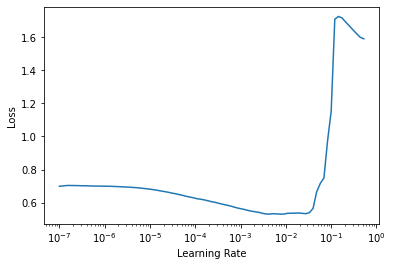

In [109]:
learn.lr_find()

In [110]:
learn.fit_one_cycle(5,0.0007)

epoch,train_loss,valid_loss,accuracy,time
0,0.623815,0.751901,0.606429,00:04
1,0.577065,0.760405,0.606429,00:03
2,0.532784,0.662953,0.609904,00:02
3,0.494725,0.615904,0.659427,00:02
4,0.464187,0.599242,0.694179,00:02


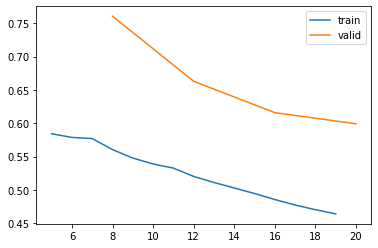

In [111]:
learn.recorder.plot_loss()

In [112]:
preds,targs = learn.get_preds()

In [113]:
np.argmax(preds, 1)

tensor([1, 1, 1,  ..., 1, 1, 1])

In [114]:
accuracy_score(targs,np.argmax(preds, 1))

0.6941789748045178

In [ ]:
## Model - team based - similar opponents as training data
获取球队最近几场与相似对手交手时，取得的数据作为training data

相似对手：

1. 将ortg和drtg作为x轴y轴，几何距离最近的对手

1. 用什么的ortg，drtg？所有本赛季已进行的比赛的数据？单场？

In [ ]:
## Model - Player based

In [ ]:
# players? -> include minutes played
# injured players?
# use news to guess how many minutes he will play